<a href="https://colab.research.google.com/github/IsaacDebrahAsirifi/Custmer-Segmentation-on-Terminated-Customers/blob/main/Customer_Segmentation_on_Terminated_Customers_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import necessary libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


import warnings

warnings.filterwarnings('ignore')

In [ ]:
#Import Data containing transactions
Rtl_data = pd.read_csv('/content/Customer Segmentation-Terminated Customers.csv', encoding = 'unicode_escape')
Rtl_data.head()

,POL_OWNER_MSISDN,ENROLMENT_DATE,TERMINATION_DATE,NUMBER_OF_TRANSACTIONS,TOTAL_GWP,LAST_TRANSACTION_DATE
0,233200225501,9/8/2018,12/6/2019,5,10.00,11/18/2019
1,233200254848,9/19/2019,10/7/2020,11,11.00,10/3/2020
2,233200277657,7/17/2019,10/8/2020,195,48.75,10/8/2020
3,233200313325,5/18/2019,3/8/2020,74,37.00,3/8/2020
4,233200321997,3/21/2020,4/15/2020,6,1.50,4/15/2020


In [ ]:
#Check the shape (number of columns and rows) in the dataset
Rtl_data.shape

(654607, 6)

In [ ]:
#Check for missing values in the dataset
Rtl_data.isnull().sum(axis=0)

POL_OWNER_MSISDN          0
ENROLMENT_DATE            0
TERMINATION_DATE          0
NUMBER_OF_TRANSACTIONS    0
TOTAL_GWP                 0
LAST_TRANSACTION_DATE     0
dtype: int64

In [ ]:
#Remove missing values from CustomerID column, can ignore missing values in description column
Rtl_data = Rtl_data[pd.notnull(Rtl_data['POL_OWNER_MSISDN'])]

#Validate if there are any negative values in Total GWP column
Rtl_data.TOTAL_GWP.min()

0.0

In [ ]:
#Convert the string dates field to datetime
Rtl_data['LAST_TRANSACTION_DATE'] = pd.to_datetime(Rtl_data['LAST_TRANSACTION_DATE'])
Rtl_data['ENROLMENT_DATE'] = pd.to_datetime(Rtl_data['ENROLMENT_DATE'])
Rtl_data['TERMINATION_DATE'] = pd.to_datetime(Rtl_data['TERMINATION_DATE'])

In [ ]:
#Check the shape (number of columns and rows) in the dataset after data is cleaned
Rtl_data.shape

(654607, 6)

In [ ]:
Rtl_data.head()

,POL_OWNER_MSISDN,ENROLMENT_DATE,TERMINATION_DATE,NUMBER_OF_TRANSACTIONS,TOTAL_GWP,LAST_TRANSACTION_DATE
0,233200225501,2018-09-08,2019-12-06,5,10.00,2019-11-18
1,233200254848,2019-09-19,2020-10-07,11,11.00,2020-10-03
2,233200277657,2019-07-17,2020-10-08,195,48.75,2020-10-08
3,233200313325,2019-05-18,2020-03-08,74,37.00,2020-03-08
4,233200321997,2020-03-21,2020-04-15,6,1.50,2020-04-15


In [ ]:
#Add new column depicting No. of Days the Customer has lasted on the Policy
Rtl_data['TERMINATED_AFTER_ENROLMENT_DAYS'] = (Rtl_data['TERMINATION_DATE'] - Rtl_data['ENROLMENT_DATE']).dt.days


Rtl_data.head()

,POL_OWNER_MSISDN,ENROLMENT_DATE,TERMINATION_DATE,NUMBER_OF_TRANSACTIONS,TOTAL_GWP,LAST_TRANSACTION_DATE,TERMINATED_AFTER_ENROLMENT_DAYS
0,233200225501,2018-09-08,2019-12-06,5,10.00,2019-11-18,454
1,233200254848,2019-09-19,2020-10-07,11,11.00,2020-10-03,384
2,233200277657,2019-07-17,2020-10-08,195,48.75,2020-10-08,449
3,233200313325,2019-05-18,2020-03-08,74,37.00,2020-03-08,295
4,233200321997,2020-03-21,2020-04-15,6,1.50,2020-04-15,25


In [ ]:
Rtl_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 654607 entries, 0 to 654606
Data columns (total 7 columns):
 #   Column                           Non-Null Count   Dtype         
---  ------                           --------------   -----         
 0   POL_OWNER_MSISDN                 654607 non-null  int64         
 1   ENROLMENT_DATE                   654607 non-null  datetime64[ns]
 2   TERMINATION_DATE                 654607 non-null  datetime64[ns]
 3   NUMBER_OF_TRANSACTIONS           654607 non-null  int64         
 4   TOTAL_GWP                        654607 non-null  float64       
 5   LAST_TRANSACTION_DATE            654607 non-null  datetime64[ns]
 6   TERMINATED_AFTER_ENROLMENT_DAYS  654607 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(3)
memory usage: 40.0 MB


## PFM Modelling

In [ ]:
#Period =  TERMINATED_AFTER_ENROLMENT_DAYS, Frequency = NUMBER_OF_TRANSACTIONS, Monetary = TOTAL_GWP
import datetime as dt

#Set Latest date 2020-12-21 as date of this analysis was on that date. This is to calculate the number of days from recent purchase
Latest_Date = dt.datetime(2020,12,21)

#Create PFM Modelling scores for each customer
#Rtl_data['NO._OF_DAYS_AFTER_TERMINATION'] = (Latest_Date - Rtl_data['TERMINATION_DATE']).dt.days


#Convert Invoice Date into type int
PFMScores= Rtl_data[['POL_OWNER_MSISDN','TERMINATED_AFTER_ENROLMENT_DAYS','NUMBER_OF_TRANSACTIONS','TOTAL_GWP']].copy()

#Rename column names to Period, Frequencyand Monetary
PFMScores.rename(columns={ 'TERMINATED_AFTER_ENROLMENT_DAYS': 'Period','NUMBER_OF_TRANSACTIONS': 'Frequency', 'TOTAL_GWP': 'Monetary'}, inplace=True)


#Creating a function to take care of customers who lasted for less than 30 days 
def handle_less_than_30_days(num):
    if num <= 30:
        return 30
    else:
        return num
#Apply handle_less_than_30_days function to Period.
PFMScores['Estimated_Period'] = [handle_less_than_30_days(x) for x in PFMScores.Period]


#Add new column depicting Average Frequency per Month & Average Monetary per Month
PFMScores['Average_Frequency'] = (30 * PFMScores['Frequency'])/PFMScores['Estimated_Period']
PFMScores['Average_Monetary'] = (30 * PFMScores['Monetary'])/PFMScores['Estimated_Period']

PFMScores.drop('Estimated_Period', inplace=True, axis=1)
PFMScores.head(10)

,POL_OWNER_MSISDN,Period,Frequency,Monetary,Average_Frequency,Average_Monetary
0,233200225501,454,5,10.00,0.330396,0.660793
1,233200254848,384,11,11.00,0.859375,0.859375
2,233200277657,449,195,48.75,13.028953,3.257238
3,233200313325,295,74,37.00,7.525424,3.762712
4,233200321997,25,6,1.50,6.000000,1.500000
5,233200322377,150,7,1.75,1.400000,0.350000
6,233200326772,450,43,21.50,2.866667,1.433333
7,233200330951,162,47,24.00,8.703704,4.444444
8,233200415852,32,13,6.75,12.187500,6.328125
9,233200463161,1,3,1.50,3.000000,1.500000


In [ ]:
#Descriptive Statistics (Period)
PFMScores.Period.describe()

count    654607.000000
mean        179.768360
std         190.789779
min           0.000000
25%          25.000000
50%         109.000000
75%         284.000000
max         980.000000
Name: Period, dtype: float64

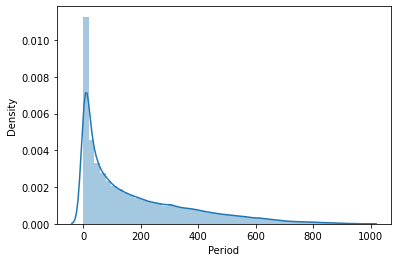

In [ ]:
#Period distribution plot
import seaborn as sns
x =PFMScores['Period']

ax = sns.distplot(x)

In [ ]:
#Descriptive Statistics (Frequency)
PFMScores.Frequency.describe()

count    654607.000000
mean         23.667720
std          33.737665
min           1.000000
25%           4.000000
50%          11.000000
75%          29.000000
max         419.000000
Name: Frequency, dtype: float64

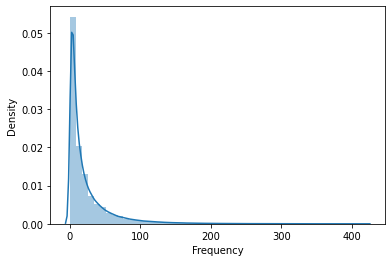

In [ ]:
#Frequency distribution plot
import seaborn as sns
x = PFMScores['Frequency']

ax = sns.distplot(x)

In [ ]:
#Descriptive Statistics (Monetary)
PFMScores.Monetary.describe()

count    654607.000000
mean          9.676324
std          11.820827
min           0.000000
25%           2.000000
50%           5.000000
75%          12.500000
max         129.000000
Name: Monetary, dtype: float64

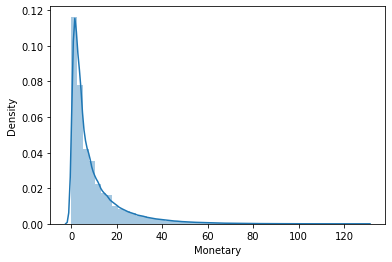

In [ ]:
#Monateray distribution plo
import seaborn as sns
x = PFMScores['Monetary']

ax = sns.distplot(x)

,Period,Frequency,Monetary,Average_Frequency,Average_Monetary
Period,1.000000,0.518672,0.667693,-0.199249,-0.252981
Frequency,0.518672,1.000000,0.829506,0.449369,0.236381
Monetary,0.667693,0.829506,1.000000,0.230218,0.270238
Average_Frequency,-0.199249,0.449369,0.230218,1.000000,0.705307
Average_Monetary,-0.252981,0.236381,0.270238,0.705307,1.000000


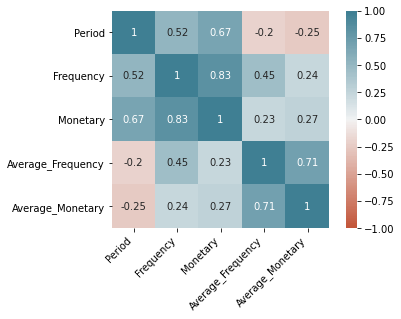

In [ ]:
#Correlation between features



corr = PFMScores[['Period','Frequency','Monetary','Average_Frequency','Average_Monetary']].corr()
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,annot = True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

#Print a Correlation Matrix

corr

In [ ]:
#Split into four segments using quantiles
quantiles = PFMScores[['Period','Frequency','Monetary']].quantile(q=[0.25,0.5,0.75])
quantiles = quantiles.to_dict()

In [ ]:
quantiles

{'Frequency': {0.25: 4.0, 0.5: 11.0, 0.75: 29.0},
 'Monetary': {0.25: 2.0, 0.5: 5.0, 0.75: 12.5},
 'Period': {0.25: 25.0, 0.5: 109.0, 0.75: 284.0}}

In [ ]:
#Functions to create R, F, M and P segments
def RScoring(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4
    
def FnMScoring(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1

In [ ]:
#Calculate Add P, F and M segment value columns in the existing dataset to show P, F and M segment values

PFMScores['P'] = PFMScores['Period'].apply(FnMScoring, args=('Period',quantiles,))
PFMScores['F'] = PFMScores['Frequency'].apply(FnMScoring, args=('Frequency',quantiles,))
PFMScores['M'] = PFMScores['Monetary'].apply(FnMScoring, args=('Monetary',quantiles,))

PFMScores.head()

,POL_OWNER_MSISDN,Period,Frequency,Monetary,Average_Frequency,Average_Monetary,P,F,M
0,233200225501,454,5,10.00,0.330396,0.660793,1,3,2
1,233200254848,384,11,11.00,0.859375,0.859375,1,3,2
2,233200277657,449,195,48.75,13.028953,3.257238,1,1,1
3,233200313325,295,74,37.00,7.525424,3.762712,1,1,1
4,233200321997,25,6,1.50,6.000000,1.500000,4,3,4


In [ ]:
#Calculate and Add PFMGroup value column showing combined concatenated score of PFM
PFMScores['PFMGroup'] = PFMScores.P.map(str) + PFMScores.F.map(str) + PFMScores.M.map(str) 

#Calculate and Add PFMScore value column showing total sum of PFMGroup values
PFMScores['PFMScore'] = PFMScores[['P', 'F', 'M']].sum(axis = 1)
PFMScores.head()

,POL_OWNER_MSISDN,Period,Frequency,Monetary,Average_Frequency,Average_Monetary,P,F,M,PFMGroup,PFMScore
0,233200225501,454,5,10.00,0.330396,0.660793,1,3,2,132,6
1,233200254848,384,11,11.00,0.859375,0.859375,1,3,2,132,6
2,233200277657,449,195,48.75,13.028953,3.257238,1,1,1,111,3
3,233200313325,295,74,37.00,7.525424,3.762712,1,1,1,111,3
4,233200321997,25,6,1.50,6.000000,1.500000,4,3,4,434,11


In [ ]:
#Assign Loyalty Level to each customer
Loyalty_Level = ['Platinum', 'Gold', 'Silver', 'Bronze']
Score_cuts = pd.qcut(PFMScores.PFMScore, q = 4, labels = Loyalty_Level)
PFMScores['PFM_Loyalty_Level'] = Score_cuts.values
PFMScores.reset_index(drop=True).head(10)

,POL_OWNER_MSISDN,Period,Frequency,Monetary,Average_Frequency,Average_Monetary,P,F,M,PFMGroup,PFMScore,PFM_Loyalty_Level
0,233200225501,454,5,10.00,0.330396,0.660793,1,3,2,132,6,Gold
1,233200254848,384,11,11.00,0.859375,0.859375,1,3,2,132,6,Gold
2,233200277657,449,195,48.75,13.028953,3.257238,1,1,1,111,3,Platinum
3,233200313325,295,74,37.00,7.525424,3.762712,1,1,1,111,3,Platinum
4,233200321997,25,6,1.50,6.000000,1.500000,4,3,4,434,11,Bronze
5,233200322377,150,7,1.75,1.400000,0.350000,2,3,4,234,9,Silver
6,233200326772,450,43,21.50,2.866667,1.433333,1,1,1,111,3,Platinum
7,233200330951,162,47,24.00,8.703704,4.444444,2,1,1,211,4,Platinum
8,233200415852,32,13,6.75,12.187500,6.328125,3,2,2,322,7,Gold
9,233200463161,1,3,1.50,3.000000,1.500000,4,4,4,444,12,Bronze


In [ ]:
#Count Each PFM_Loyalty_Level
PFMScores.PFM_Loyalty_Level.value_counts()

Platinum    200595
Gold        180055
Bronze      151083
Silver      122874
Name: PFM_Loyalty_Level, dtype: int64

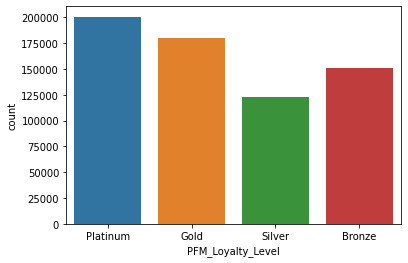

In [ ]:
ax = sns.countplot(x="PFM_Loyalty_Level", data=PFMScores)

In [ ]:
#Count Each RFMPScore
PFMScores.PFMScore.value_counts()

12    87794
3     79506
4     68542
9     65121
6     63300
11    63289
7     61137
10    57753
8     55618
5     52547
Name: PFMScore, dtype: int64

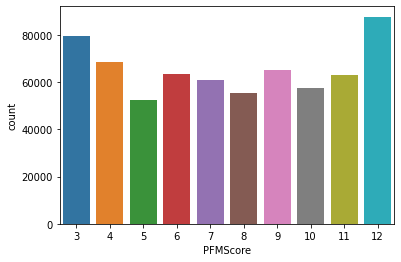

In [ ]:
ax = sns.countplot(x="PFMScore", data=PFMScores)

In [ ]:
#Validate the data for PFMGroup = 111
PFMScores[PFMScores['PFMGroup']=='111'].sort_values('Monetary', ascending=False).reset_index(drop=True).head(10)

,POL_OWNER_MSISDN,Period,Frequency,Monetary,Average_Frequency,Average_Monetary,P,F,M,PFMGroup,PFMScore,PFM_Loyalty_Level
0,233542154755,960,258,129.0,8.062500,4.031250,1,1,1,111,3,Platinum
1,233240480360,907,245,122.0,8.103638,4.035281,1,1,1,111,3,Platinum
2,233243899855,878,237,118.5,8.097950,4.048975,1,1,1,111,3,Platinum
3,233543141385,923,117,117.0,3.802817,3.802817,1,1,1,111,3,Platinum
4,233243489148,936,139,117.0,4.455128,3.750000,1,1,1,111,3,Platinum
5,233248850474,899,117,116.0,3.904338,3.870968,1,1,1,111,3,Platinum
6,233248699376,907,116,116.0,3.836825,3.836825,1,1,1,111,3,Platinum
7,233245748643,870,231,115.5,7.965517,3.982759,1,1,1,111,3,Platinum
8,233240930886,891,229,114.5,7.710438,3.855219,1,1,1,111,3,Platinum
9,233243123761,903,114,114.0,3.787375,3.787375,1,1,1,111,3,Platinum


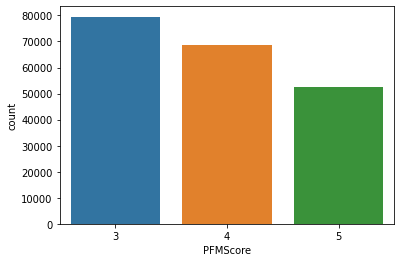

In [ ]:
ax = sns.countplot(x="PFMScore", data=PFMScores[PFMScores['PFM_Loyalty_Level']=='Platinum'])

In [ ]:
#Validate the data for PFMGroup = 444
PFMScores[PFMScores['PFMGroup']=='444'].sort_values('Monetary', ascending=False).reset_index(drop=True).head(10)

,POL_OWNER_MSISDN,Period,Frequency,Monetary,Average_Frequency,Average_Monetary,P,F,M,PFMGroup,PFMScore,PFM_Loyalty_Level
0,233248836496,7,2,2.0,2.0,2.0,4,4,4,444,12,Bronze
1,233558816998,24,4,2.0,4.0,2.0,4,4,4,444,12,Bronze
2,233245781575,4,4,2.0,4.0,2.0,4,4,4,444,12,Bronze
3,233541783824,5,4,2.0,4.0,2.0,4,4,4,444,12,Bronze
4,233245780283,1,1,2.0,1.0,2.0,4,4,4,444,12,Bronze
5,233558823593,5,4,2.0,4.0,2.0,4,4,4,444,12,Bronze
6,233558824226,15,4,2.0,4.0,2.0,4,4,4,444,12,Bronze
7,233245778895,0,3,2.0,3.0,2.0,4,4,4,444,12,Bronze
8,233552022172,3,1,2.0,1.0,2.0,4,4,4,444,12,Bronze
9,233541786505,24,4,2.0,4.0,2.0,4,4,4,444,12,Bronze


In [ ]:
#Validate the data for PFMGroup = 441
PFMScores[PFMScores['PFMGroup']=='443'].sort_values('Period', ascending=False).reset_index(drop=True).head(10)

,POL_OWNER_MSISDN,Period,Frequency,Monetary,Average_Frequency,Average_Monetary,P,F,M,PFMGroup,PFMScore,PFM_Loyalty_Level
0,233555506107,25,4,3.25,4.0,3.25,4,4,3,443,11,Bronze
1,233591714212,25,4,4.00,4.0,4.00,4,4,3,443,11,Bronze
2,233246142894,25,2,4.00,2.0,4.00,4,4,3,443,11,Bronze
3,233549722337,25,2,2.25,2.0,2.25,4,4,3,443,11,Bronze
4,233591846479,25,4,2.75,4.0,2.75,4,4,3,443,11,Bronze
5,233591860566,25,3,3.75,3.0,3.75,4,4,3,443,11,Bronze
6,233547040373,25,4,2.75,4.0,2.75,4,4,3,443,11,Bronze
7,233546253231,25,3,4.25,3.0,4.25,4,4,3,443,11,Bronze
8,233540166193,25,3,2.25,3.0,2.25,4,4,3,443,11,Bronze
9,233594987951,25,3,2.75,3.0,2.75,4,4,3,443,11,Bronze


In [ ]:
! pip install chart_studio

In [ ]:
#Sample from the whole population for Visualization
df_LF = PFMScores.sample(n=70000, replace=True, random_state=1)


print("Shape of dataframe is: {}".format(df_LF.shape))
df_LF.reset_index(drop=True).head(10)

Shape of dataframe is: (70000, 12)


,POL_OWNER_MSISDN,Period,Frequency,Monetary,Average_Frequency,Average_Monetary,P,F,M,PFMGroup,PFMScore,PFM_Loyalty_Level
0,233245721334,33,7,6.00,6.363636,5.454545,3,3,2,332,8,Gold
1,233553678518,403,106,26.50,7.890819,1.972705,1,1,1,111,3,Platinum
2,233552587163,16,8,4.00,8.000000,4.000000,4,3,3,433,10,Silver
3,233553654814,14,10,2.50,10.000000,2.500000,4,3,3,433,10,Silver
4,233547244258,75,37,9.25,14.800000,3.700000,3,1,2,312,6,Gold
5,233243066258,398,62,15.50,4.673367,1.168342,1,1,1,111,3,Platinum
6,233245274265,68,6,3.00,2.647059,1.323529,3,3,3,333,9,Silver
7,233240915999,117,1,1.00,0.256410,0.256410,2,4,4,244,10,Silver
8,233274409741,150,2,1.50,0.400000,0.300000,2,4,4,244,10,Silver
9,233549315230,233,3,6.00,0.386266,0.772532,2,4,2,242,8,Gold


In [ ]:
import chart_studio as cs
import plotly.offline as po
import plotly.graph_objs as gobj

#Period Vs Frequency
graph = df_LF

plot_data = [
    gobj.Scatter(
        x=graph.query("PFM_Loyalty_Level == 'Bronze'")['Period'],
        y=graph.query("PFM_Loyalty_Level == 'Bronze'")['Frequency'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("PFM_Loyalty_Level == 'Silver'")['Period'],
        y=graph.query("PFM_Loyalty_Level == 'Silver'")['Frequency'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("PFM_Loyalty_Level == 'Gold'")['Period'],
        y=graph.query("PFM_Loyalty_Level == 'Gold'")['Frequency'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("PFM_Loyalty_Level == 'Platinum'")['Period'],
        y=graph.query("PFM_Loyalty_Level == 'Platinum'")['Frequency'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Period"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

#Frequency Vs Monetary
graph = df_LF

plot_data = [
    gobj.Scatter(
        x=graph.query("PFM_Loyalty_Level == 'Bronze'")['Frequency'],
        y=graph.query("PFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("PFM_Loyalty_Level == 'Silver'")['Frequency'],
        y=graph.query("PFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("PFM_Loyalty_Level == 'Gold'")['Frequency'],
        y=graph.query("PFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("PFM_Loyalty_Level == 'Platinum'")['Frequency'],
        y=graph.query("PFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)

#Period Vs Monetary
graph = df_LF

plot_data = [
    gobj.Scatter(
        x=graph.query("PFM_Loyalty_Level == 'Bronze'")['Period'],
        y=graph.query("PFM_Loyalty_Level == 'Bronze'")['Monetary'],
        mode='markers',
        name='Bronze',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        gobj.Scatter(
        x=graph.query("PFM_Loyalty_Level == 'Silver'")['Period'],
        y=graph.query("PFM_Loyalty_Level == 'Silver'")['Monetary'],
        mode='markers',
        name='Silver',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        gobj.Scatter(
        x=graph.query("PFM_Loyalty_Level == 'Gold'")['Period'],
        y=graph.query("PFM_Loyalty_Level == 'Gold'")['Monetary'],
        mode='markers',
        name='Gold',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
    gobj.Scatter(
        x=graph.query("PFM_Loyalty_Level == 'Platinum'")['Period'],
        y=graph.query("PFM_Loyalty_Level == 'Platinum'")['Monetary'],
        mode='markers',
        name='Platinum',
        marker= dict(size= 13,
            line= dict(width=1),
            color= 'black',
            opacity= 0.9
           )
    ),
]

plot_layout = gobj.Layout(
        yaxis= {'title': "Monetary"},
        xaxis= {'title': "Period"},
        title='Segments'
    )
fig = gobj.Figure(data=plot_data, layout=plot_layout)
po.iplot(fig)




## K-Means Clustering

In [ ]:
#Handle negative and zero values so as to handle infinite numbers during log transformation
def handle_neg_n_zero(num):
    if num <= 0:
        return 1
    else:
        return num

    
#Apply handle_neg_n_zero function to Period and Monetary columns 
PFMScores['Period'] = [handle_neg_n_zero(x) for x in PFMScores.Period]
PFMScores['Monetary'] = [handle_neg_n_zero(x) for x in PFMScores.Monetary]
PFMScores['Frequency'] = [handle_neg_n_zero(x) for x in PFMScores.Frequency]
PFMScores['Average_Frequency'] = [handle_neg_n_zero(x) for x in PFMScores.Average_Frequency]
PFMScores['Average_Monetary'] = [handle_neg_n_zero(x) for x in PFMScores.Average_Monetary]

#Perform Log transformation to bring data into normal or near normal distribution
Log_Tfd_Data = PFMScores[['Period', 'Frequency', 'Monetary','Average_Frequency','Average_Monetary']].apply(np.log, axis = 1).round(3)

In [ ]:
#Perform Standard Normal Transformation to bring data into normal or near normal distribution
from sklearn import preprocessing


def standard_normalized_vars(x):
    column_names = []
    for i in range(0,len(x.columns)):
        if x.dtypes[i] in ['int64','float64','uint8']:
            column_names.append(x.columns[i])    
    x[column_names] = x[column_names].fillna(0)
    x[column_names] = x[column_names].astype(float)
    df = x[column_names].values #returns a numpy array
    min_max_scaler = preprocessing.StandardScaler()
    x_scaled = min_max_scaler.fit_transform(df)
    df = pd.DataFrame(x_scaled)
    df.columns = column_names
    x[column_names] = df[column_names]
    return x

### Scaling

Scale so all numbers are proportional

In [ ]:
Log_Tfd_Data = standard_normalized_vars(PFMScores[['Period', 'Frequency', 'Monetary','Average_Frequency','Average_Monetary']])

Log_Tfd_Data.head(10)

,Period,Frequency,Monetary,Average_Frequency,Average_Monetary
0,1.437351,-0.553320,0.027382,-1.025254,-0.890772
1,1.070455,-0.375477,0.111978,-0.902105,-0.752926
2,1.411144,5.078372,3.305497,1.931053,0.911554
3,0.603972,1.491873,2.311488,0.649796,1.262429
4,-0.811199,-0.523680,-0.691688,0.294667,-0.308235
5,-0.156027,-0.494039,-0.670539,-0.776244,-1.106509
6,1.416385,0.573018,1.000242,-0.434794,-0.354512
7,-0.093131,0.691580,1.211733,0.924107,1.735655
8,-0.774509,-0.316196,-0.247557,1.735158,3.043214
9,-0.936992,-0.612601,-0.691688,-0.403753,-0.308235


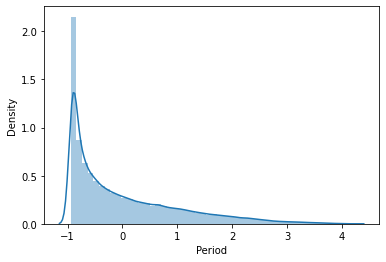

In [ ]:
#Data distribution after data normalization for Period
Period_Plot = Log_Tfd_Data['Period']
ax = sns.distplot(Period_Plot)

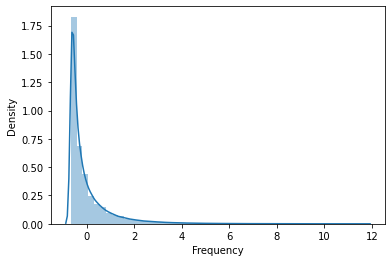

In [ ]:
#Data distribution after data normalization for Frequency
Frequency_Plot = Log_Tfd_Data['Frequency']
ax = sns.distplot(Frequency_Plot)

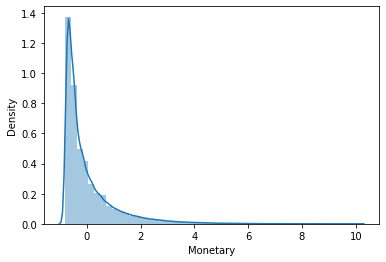

In [ ]:
#Data distribution after data normalization for Monetary
Monetary_Plot = Log_Tfd_Data['Monetary']
ax = sns.distplot(Monetary_Plot)

In [ ]:
from sklearn.preprocessing import StandardScaler

#Bring the data on same scale
scaleobj = StandardScaler()
Scaled_Data = scaleobj.fit_transform(Log_Tfd_Data)

#Transform it back to dataframe
Scaled_Data = pd.DataFrame(Scaled_Data, index = PFMScores.index, columns = Log_Tfd_Data.columns)

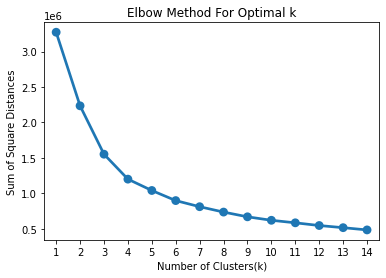

In [ ]:
from sklearn.cluster import KMeans

sum_of_sq_dist = {}
for k in range(1,15):
    km = KMeans(n_clusters= k, init= 'k-means++', max_iter= 1000)
    km = km.fit(Scaled_Data)
    sum_of_sq_dist[k] = km.inertia_
    
#Plot the graph for the sum of square distance values and Number of Clusters
sns.pointplot(x = list(sum_of_sq_dist.keys()), y = list(sum_of_sq_dist.values()))
plt.xlabel('Number of Clusters(k)')
plt.ylabel('Sum of Square Distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
#Perform K-Mean Clustering or build the K-Means clustering model
KMean_clust = KMeans(n_clusters= 4, init= 'k-means++', max_iter= 1000)
KMean_clust.fit(Scaled_Data)

#Find the clusters for the observation given in the dataset
PFMScores['Cluster'] = KMean_clust.labels_
PFMScores.head(10)

,POL_OWNER_MSISDN,Period,Frequency,Monetary,Average_Frequency,Average_Monetary,P,F,M,PFMGroup,PFMScore,PFM_Loyalty_Level,Cluster
0,233200225501,454,5,10.00,0.330396,0.660793,1,3,2,132,6,Gold,1
1,233200254848,384,11,11.00,0.859375,0.859375,1,3,2,132,6,Gold,1
2,233200277657,449,195,48.75,13.028953,3.257238,1,1,1,111,3,Platinum,3
3,233200313325,295,74,37.00,7.525424,3.762712,1,1,1,111,3,Platinum,3
4,233200321997,25,6,1.50,6.000000,1.500000,4,3,4,434,11,Bronze,0
5,233200322377,150,7,1.75,1.400000,0.350000,2,3,4,234,9,Silver,0
6,233200326772,450,43,21.50,2.866667,1.433333,1,1,1,111,3,Platinum,1
7,233200330951,162,47,24.00,8.703704,4.444444,2,1,1,211,4,Platinum,2
8,233200415852,32,13,6.75,12.187500,6.328125,3,2,2,322,7,Gold,2
9,233200463161,1,3,1.50,3.000000,1.500000,4,4,4,444,12,Bronze,0


<Figure size 504x504 with 0 Axes>

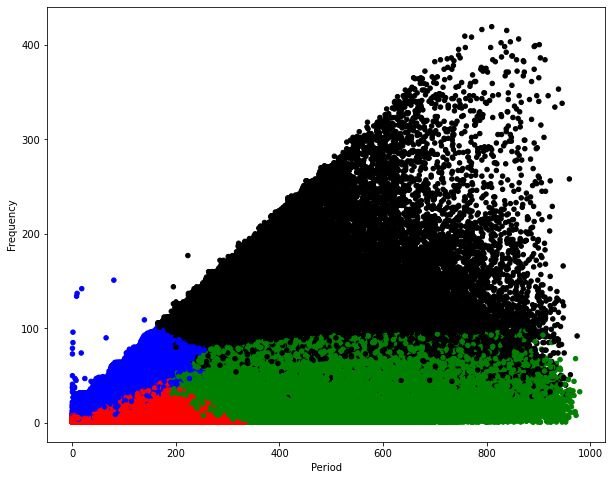

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(7,7))

##Scatter Plot Frequency Vs Period
Colors = ["red", "green", "blue","black"]
PFMScores['Color'] = PFMScores['Cluster'].map(lambda p: Colors[p])
ax = PFMScores.plot(    
    kind="scatter", 
    x="Period", y="Frequency",
    figsize=(10,8),
    c = PFMScores['Color']
)


<Figure size 504x504 with 0 Axes>

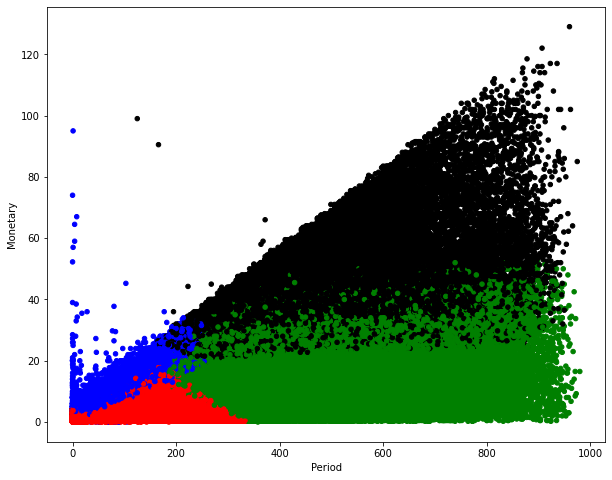

In [ ]:
plt.figure(figsize=(7,7))

##Scatter Plot Monetary Vs Period
Colors = ["red", "green", "blue","black"]
PFMScores['Color'] = PFMScores['Cluster'].map(lambda p: Colors[p])
ax = PFMScores.plot(    
    kind="scatter", 
    x="Period", y="Monetary",
    figsize=(10,8),
    c = PFMScores['Color']
)

<Figure size 504x504 with 0 Axes>

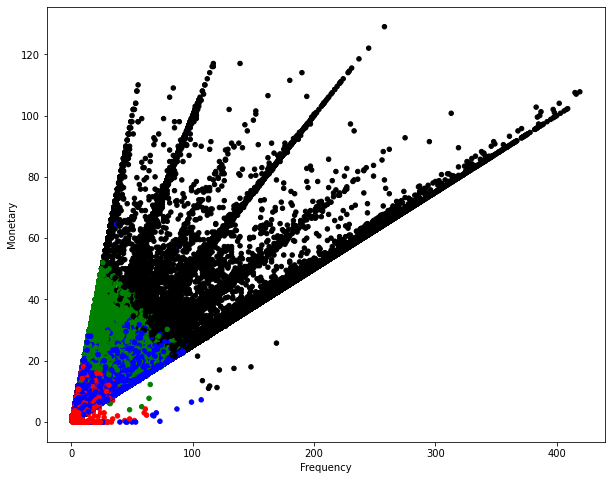

In [ ]:
plt.figure(figsize=(7,7))

##Scatter Plot Monetary Vs Frequency
Colors = ["red", "green", "blue","black"]
PFMScores['Color'] = PFMScores['Cluster'].map(lambda p: Colors[p])
ax = PFMScores.plot(    
    kind="scatter", 
    x="Frequency", y="Monetary",
    figsize=(10,8),
    c = PFMScores['Color']
)

In [ ]:
PFMScores.head(10)

,POL_OWNER_MSISDN,Period,Frequency,Monetary,Average_Frequency,Average_Monetary,P,F,M,PFMGroup,PFMScore,PFM_Loyalty_Level,Cluster,Color
0,233200225501,454,5,10.00,0.330396,0.660793,1,3,2,132,6,Gold,1,green
1,233200254848,384,11,11.00,0.859375,0.859375,1,3,2,132,6,Gold,1,green
2,233200277657,449,195,48.75,13.028953,3.257238,1,1,1,111,3,Platinum,3,black
3,233200313325,295,74,37.00,7.525424,3.762712,1,1,1,111,3,Platinum,3,black
4,233200321997,25,6,1.50,6.000000,1.500000,4,3,4,434,11,Bronze,0,red
5,233200322377,150,7,1.75,1.400000,0.350000,2,3,4,234,9,Silver,0,red
6,233200326772,450,43,21.50,2.866667,1.433333,1,1,1,111,3,Platinum,1,green
7,233200330951,162,47,24.00,8.703704,4.444444,2,1,1,211,4,Platinum,2,blue
8,233200415852,32,13,6.75,12.187500,6.328125,3,2,2,322,7,Gold,2,blue
9,233200463161,1,3,1.50,3.000000,1.500000,4,4,4,444,12,Bronze,0,red


In [ ]:
#Validate the data for Cluster = 3
PFMScores[PFMScores['Cluster']==3].sort_values('Monetary', ascending=True).reset_index(drop=True).head(10)

,POL_OWNER_MSISDN,Period,Frequency,Monetary,Average_Frequency,Average_Monetary,P,F,M,PFMGroup,PFMScore,PFM_Loyalty_Level,Cluster,Color
0,233559030980,273,113,11.00,12.417582,1.208791,2,1,2,212,5,Platinum,3,black
1,233554619889,231,120,11.25,15.584416,1.461039,2,1,2,212,5,Platinum,3,black
2,233591347066,252,114,11.75,13.571429,1.398810,2,1,2,212,5,Platinum,3,black
3,233545145834,290,108,13.50,11.172414,1.396552,1,1,1,111,3,Platinum,3,black
4,233541395706,328,122,17.00,11.158537,1.554878,1,1,1,111,3,Platinum,3,black
5,233557179465,247,134,17.50,16.275304,2.125506,2,1,1,211,4,Platinum,3,black
6,233245462324,339,148,18.00,13.097345,1.592920,1,1,1,111,3,Platinum,3,black
7,233593340365,261,79,19.75,9.080460,2.270115,2,1,1,211,4,Platinum,3,black
8,233557115478,262,79,19.75,9.045802,2.261450,2,1,1,211,4,Platinum,3,black
9,233544701376,261,79,19.75,9.080460,2.270115,2,1,1,211,4,Platinum,3,black


In [ ]:
#Validate the data for PFMGroup = 111
PFMScores[PFMScores['PFMGroup']=='111'].sort_values('Monetary', ascending=True).reset_index(drop=True).head(10)

,POL_OWNER_MSISDN,Period,Frequency,Monetary,Average_Frequency,Average_Monetary,P,F,M,PFMGroup,PFMScore,PFM_Loyalty_Level,Cluster,Color
0,233541796001,420,51,12.75,3.642857,0.910714,1,1,1,111,3,Platinum,1,green
1,233242604632,428,51,12.75,3.574766,0.893692,1,1,1,111,3,Platinum,1,green
2,233542030048,401,50,12.75,3.740648,0.953865,1,1,1,111,3,Platinum,1,green
3,233241587401,398,51,12.75,3.844221,0.961055,1,1,1,111,3,Platinum,1,green
4,233548539548,303,51,12.75,5.049505,1.262376,1,1,1,111,3,Platinum,1,green
5,233241969459,304,51,12.75,5.032895,1.258224,1,1,1,111,3,Platinum,1,green
6,233247446044,345,48,12.75,4.173913,1.108696,1,1,1,111,3,Platinum,1,green
7,233544077521,300,40,12.75,4.000000,1.275000,1,1,1,111,3,Platinum,1,green
8,233247431218,513,48,12.75,2.807018,0.745614,1,1,1,111,3,Platinum,1,green
9,233542506171,356,51,12.75,4.297753,1.074438,1,1,1,111,3,Platinum,1,green


In [ ]:
#Validate the data for Cluster = 0
PFMScores[PFMScores['Cluster']==0].sort_values('Monetary', ascending=True).reset_index(drop=True).head(10)

,POL_OWNER_MSISDN,Period,Frequency,Monetary,Average_Frequency,Average_Monetary,P,F,M,PFMGroup,PFMScore,PFM_Loyalty_Level,Cluster,Color
0,233246848624,0,2,0.0,2.000000,0.0,4,4,4,444,12,Bronze,0,red
1,233553442367,14,6,0.0,6.000000,0.0,4,3,4,434,11,Bronze,0,red
2,233542537646,126,24,0.0,5.714286,0.0,2,2,4,224,8,Gold,0,red
3,233248993479,91,3,0.0,0.989011,0.0,3,4,4,344,11,Bronze,0,red
4,233245632162,27,8,0.0,8.000000,0.0,3,3,4,334,10,Silver,0,red
5,233244029937,11,4,0.0,4.000000,0.0,4,4,4,444,12,Bronze,0,red
6,233556558320,73,5,0.0,2.054795,0.0,3,3,4,334,10,Silver,0,red
7,233546558869,0,2,0.0,2.000000,0.0,4,4,4,444,12,Bronze,0,red
8,233553800446,21,14,0.0,14.000000,0.0,4,2,4,424,10,Silver,0,red
9,233247563265,56,8,0.0,4.285714,0.0,3,3,4,334,10,Silver,0,red


In [ ]:
#Validate the data for Cluster = 2
PFMScores[PFMScores['Cluster']==2].sort_values('Monetary', ascending=True).reset_index(drop=True).head(10)

,POL_OWNER_MSISDN,Period,Frequency,Monetary,Average_Frequency,Average_Monetary,P,F,M,PFMGroup,PFMScore,PFM_Loyalty_Level,Cluster,Color
0,233550503954,19,16,0.0,16.000000,0.0,4,2,4,424,10,Silver,2,blue
1,233555369125,51,26,0.0,15.294118,0.0,3,2,4,324,9,Silver,2,blue
2,233246503471,105,50,0.0,14.285714,0.0,3,1,4,314,8,Gold,2,blue
3,233547975818,81,46,0.0,17.037037,0.0,3,1,4,314,8,Gold,2,blue
4,233248991374,70,45,0.0,19.285714,0.0,3,1,4,314,8,Gold,2,blue
5,233551895514,70,40,0.0,17.142857,0.0,3,1,4,314,8,Gold,2,blue
6,233247851284,35,27,0.0,23.142857,0.0,3,2,4,324,9,Silver,2,blue
7,233550706463,89,53,0.0,17.865169,0.0,3,1,4,314,8,Gold,2,blue
8,233246753104,25,16,0.0,16.000000,0.0,4,2,4,424,10,Silver,2,blue
9,233243790120,45,30,0.0,20.000000,0.0,3,1,4,314,8,Gold,2,blue


In [ ]:
#Validate the data for Cluster = 1
PFMScores[PFMScores['Cluster']==1].sort_values('Monetary', ascending=True).reset_index(drop=True).head(10)

,POL_OWNER_MSISDN,Period,Frequency,Monetary,Average_Frequency,Average_Monetary,P,F,M,PFMGroup,PFMScore,PFM_Loyalty_Level,Cluster,Color
0,233555523836,358,1,0.00,0.083799,0.000000,1,4,4,144,9,Silver,1,green
1,233241556418,574,1,0.25,0.052265,0.013066,1,4,4,144,9,Silver,1,green
2,233550922783,686,1,0.25,0.043732,0.010933,1,4,4,144,9,Silver,1,green
3,233541909436,446,1,0.25,0.067265,0.016816,1,4,4,144,9,Silver,1,green
4,233552850320,501,1,0.25,0.059880,0.014970,1,4,4,144,9,Silver,1,green
5,233240375021,391,1,0.25,0.076726,0.019182,1,4,4,144,9,Silver,1,green
6,233545511840,439,1,0.25,0.068337,0.017084,1,4,4,144,9,Silver,1,green
7,233554973193,617,1,0.25,0.048622,0.012156,1,4,4,144,9,Silver,1,green
8,233543756249,498,1,0.25,0.060241,0.015060,1,4,4,144,9,Silver,1,green
9,233559881653,497,1,0.25,0.060362,0.015091,1,4,4,144,9,Silver,1,green


In [ ]:
PFMScores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 654607 entries, 0 to 654606
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   POL_OWNER_MSISDN   654607 non-null  int64   
 1   Period             654607 non-null  int64   
 2   Frequency          654607 non-null  int64   
 3   Monetary           654607 non-null  float64 
 4   Average_Frequency  654607 non-null  float64 
 5   Average_Monetary   654607 non-null  float64 
 6   P                  654607 non-null  int64   
 7   F                  654607 non-null  int64   
 8   M                  654607 non-null  int64   
 9   PFMGroup           654607 non-null  object  
 10  PFMScore           654607 non-null  int64   
 11  PFM_Loyalty_Level  654607 non-null  category
 12  Cluster            654607 non-null  int32   
 13  Color              654607 non-null  object  
dtypes: category(1), float64(3), int32(1), int64(7), object(2)
memory usage: 88.0+ MB


In [ ]:
PFMScores['POL_OWNER_MSISDN'] = PFMScores['POL_OWNER_MSISDN'].astype(str)

PFMScores.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 654607 entries, 0 to 654606
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   POL_OWNER_MSISDN   654607 non-null  object  
 1   Period             654607 non-null  int64   
 2   Frequency          654607 non-null  int64   
 3   Monetary           654607 non-null  float64 
 4   Average_Frequency  654607 non-null  float64 
 5   Average_Monetary   654607 non-null  float64 
 6   P                  654607 non-null  int64   
 7   F                  654607 non-null  int64   
 8   M                  654607 non-null  int64   
 9   PFMGroup           654607 non-null  object  
 10  PFMScore           654607 non-null  int64   
 11  PFM_Loyalty_Level  654607 non-null  category
 12  Cluster            654607 non-null  int32   
 13  Color              654607 non-null  object  
dtypes: category(1), float64(3), int32(1), int64(6), object(3)
memory usage: 88.0+ MB


In [ ]:
PFMScores.head()

,POL_OWNER_MSISDN,Period,Frequency,Monetary,Average_Frequency,Average_Monetary,P,F,M,PFMGroup,PFMScore,PFM_Loyalty_Level,Cluster,Color
0,233200225501,454,5,10.00,0.330396,0.660793,1,3,2,132,6,Gold,1,green
1,233200254848,384,11,11.00,0.859375,0.859375,1,3,2,132,6,Gold,1,green
2,233200277657,449,195,48.75,13.028953,3.257238,1,1,1,111,3,Platinum,3,black
3,233200313325,295,74,37.00,7.525424,3.762712,1,1,1,111,3,Platinum,3,black
4,233200321997,25,6,1.50,6.000000,1.500000,4,3,4,434,11,Bronze,0,red


In [ ]:

PFMScores.to_csv (r'/content/Customer Segmentation-Terminated Customers(Final Data).csv', index = False, header=True)